In [ ]:
ladec_df

,id_master,c1,c2,stim,obs,obsc1,obsc2,stimlen,c1len,c2len,...,Juhasz_tran,st_c1_mean,st_c2_mean,Zipfvalue,c1_SLlg10wf,c2_SLlg10wf,c1_BLPbncfrequency,c1_BLPbncfrequencymillion,c2_BLPbncfrequency,c2_BLPbncfrequencymillion
0,3237,gad,about,gadabout,1,4,3,8,3,5,...,NaN,NaN,NaN,1.768955,1.4314,5.2677,28.0,0.280000,197116.0,1971.160000
1,4592,knock,about,knockabout,1,3,4,10,5,5,...,NaN,NaN,NaN,1.592864,3.5185,5.2677,1975.0,19.750000,197116.0,1971.160000
2,8231,turn,about,turnabout,1,19,7,9,4,5,...,NaN,4.452,2.813,2.333227,4.1940,5.2677,21026.0,210.259990,197116.0,1971.160000
3,6139,race,about,raceabout,1,4,1,9,4,5,...,NaN,NaN,NaN,NaN,3.4994,5.2677,7959.0,79.589996,197116.0,1971.160000
4,8331,walk,about,walkabout,1,2,5,9,4,5,...,NaN,4.594,2.733,2.246077,4.0418,5.2677,10441.0,104.410000,197116.0,1971.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8951,4515,junk,yards,junkyards,1,1,10,9,4,5,...,NaN,NaN,NaN,1.592864,2.8949,2.8814,623.0,6.230000,3678.0,36.779999
8952,6812,ship,yards,shipyards,1,10,9,9,4,5,...,NaN,NaN,NaN,2.570588,3.7028,2.8814,4729.0,47.290001,3678.0,36.779999
8953,2667,farm,yards,farmyards,1,10,6,9,4,5,...,NaN,NaN,NaN,1.592864,3.1855,2.8814,6913.0,69.129997,3678.0,36.779999
8954,1007,brick,yards,brickyards,1,8,12,10,5,5,...,NaN,NaN,NaN,NaN,2.7160,2.8814,1861.0,18.610001,3678.0,36.779999


In [ ]:
compounds_df = pd.read_csv(data_path)

In [ ]:
compounds_df

,Unnamed: 0,Compound,left,right,TRAN,LMD
0,0,aboveground,above,ground,6.200000,4.000000
1,1,airbase,air,base,4.266667,5.866667
2,2,airborne,air,borne,3.857143,3.133333
3,3,aircraft,air,craft,4.533333,4.266667
4,4,airfield,air,field,4.333333,5.714286
...,...,...,...,...,...,...
623,624,wordplay,word,play,4.928571,3.533333
624,625,worldwide,world,wide,4.928571,3.066667
625,626,wristwatch,wrist,watch,6.266667,6.333333
626,627,yardstick,yards,tick,5.866667,5.333333


<ipython-input-6-8c5f4bc01c90>:84: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_a = spearmanr(y_te_a, y_pred_a)
<ipython-input-6-8c5f4bc01c90>:96: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp_lmd = spearmanr(y_te_p, y_pred_p)


Association (BERT) -> MAE: 6.8624, Spearman: nan (p=nan)
LMD (BERT) -> MAE: 1.2356, Spearman: nan (p=nan)


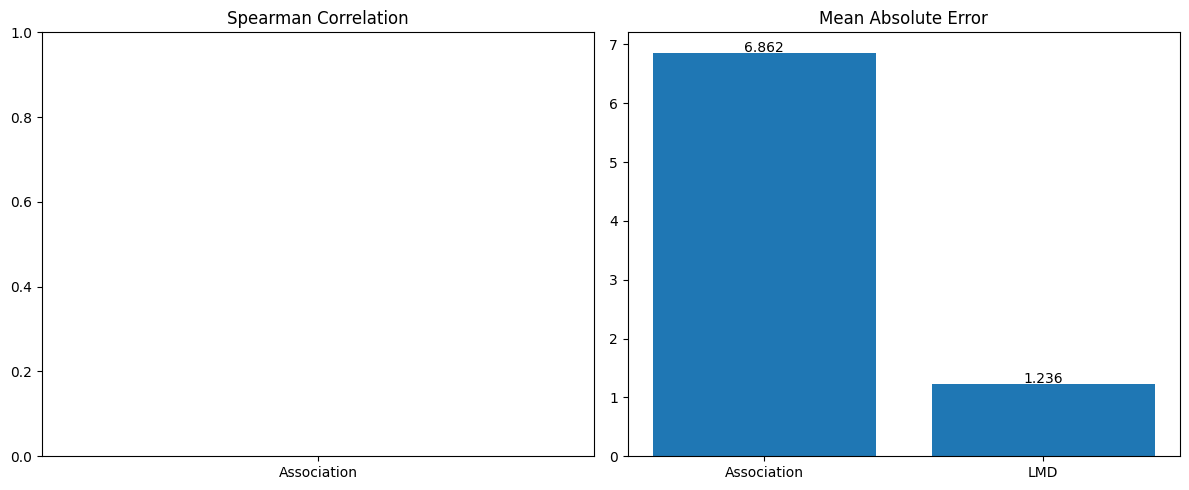

In [ ]:
import json
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

# 1. Load Data and Resources
# ---------------------------
# Path to compounds data (should include columns: 'compound','left','right','association','LMD','TRAN')
data_path = "compounds.csv"
thesaurus_path = "ea-thesaurus.json"

compounds_df = pd.read_csv(data_path)
with open(thesaurus_path, 'r') as f:
    thesaurus = json.load(f)

# Association lookup
def get_association(thesaurus, w1, w2):
    for entry in thesaurus.get(w1.upper(), []):
        if w2.upper() in entry:
            return entry[w2.upper()]
    return np.nan

# Add association if missing
if 'association' not in compounds_df.columns:
    compounds_df['association'] = compounds_df.apply(
        lambda row: get_association(thesaurus, row['left'], row['right']), axis=1)

# Drop rows missing key measures
compounds_df.dropna(subset=['association', 'LMD', 'TRAN'], inplace=True)

# 2. Obtain BERT_base Embeddings
# -------------------------------
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

def bert_embeddings(texts, batch_size=32, device='cpu'):
    all_emb = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
            out = model(**enc.to(device))
            last_hidden = out.last_hidden_state
            mask = enc['attention_mask'].unsqueeze(-1)
            summed = (last_hidden * mask).sum(dim=1)
            counts = mask.sum(dim=1)
            mean_pooled = summed / counts
            all_emb.append(mean_pooled.cpu().numpy())
    return np.vstack(all_emb)

# Compute embeddings
compounds = compounds_df['Compound'].tolist()
emb_c = bert_embeddings(compounds)
emb_l = bert_embeddings(compounds_df['left'].tolist())
emb_r = bert_embeddings(compounds_df['right'].tolist())

# 3. Compute LMD and Semantic Transparency (ST)
# ---------------------------------------------
L_cos = np.einsum('ij,ij->i', emb_c, emb_l) / (np.linalg.norm(emb_c,axis=1)*np.linalg.norm(emb_l,axis=1))
R_cos = np.einsum('ij,ij->i', emb_c, emb_r) / (np.linalg.norm(emb_c,axis=1)*np.linalg.norm(emb_r,axis=1))
# definitions
bert_LMD = 5 * (R_cos - L_cos) + 5
bert_ST  = 3 * (R_cos + L_cos) + 1
compounds_df['bert_LMD'] = bert_LMD
compounds_df['bert_ST']  = bert_ST

# 4. Regressor: Association
# -------------------------
X_assoc = compounds_df[['bert_LMD', 'bert_ST']]
y_assoc = compounds_df['association']
X_tr_a, X_te_a, y_tr_a, y_te_a = train_test_split(X_assoc, y_assoc, test_size=0.3, random_state=42)
model_assoc = Lasso(alpha=1.0)
model_assoc.fit(X_tr_a, y_tr_a)
y_pred_a = model_assoc.predict(X_te_a)
mae_assoc = mean_absolute_error(y_te_a, y_pred_a)
sp_a = spearmanr(y_te_a, y_pred_a)
print(f"Association (BERT) -> MAE: {mae_assoc:.4f}, Spearman: {sp_a.correlation:.4f} (p={sp_a.pvalue:.3g})")

# 5. Regressor: LMD (in place of predictability)
# ----------------------------------------------
X_lmd = compounds_df[['bert_LMD', 'bert_ST']]
y_lmd = compounds_df['LMD']
X_tr_p, X_te_p, y_tr_p, y_te_p = train_test_split(X_lmd, y_lmd, test_size=0.3, random_state=42)
model_lmd = Lasso(alpha=1.0)
model_lmd.fit(X_tr_p, y_tr_p)
y_pred_p = model_lmd.predict(X_te_p)
mae_lmd = mean_absolute_error(y_te_p, y_pred_p)
sp_lmd = spearmanr(y_te_p, y_pred_p)
print(f"LMD (BERT) -> MAE: {mae_lmd:.4f}, Spearman: {sp_lmd.correlation:.4f} (p={sp_lmd.pvalue:.3g})")

# 6. Plot Spearman & MAE Comparison
# ---------------------------------
tasks = ['Association', 'LMD']
spearmans = [sp_a.correlation, sp_lmd.correlation]
maes = [mae_assoc, mae_lmd]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Spearman
axes[0].bar(tasks, spearmans)
for i, v in enumerate(spearmans): axes[0].text(i, v+0.01, f"{v:.3f}", ha='center')
axes[0].set_title('Spearman Correlation')
axes[0].set_ylim(0, 1)
# MAE
axes[1].bar(tasks, maes)
for i, v in enumerate(maes): axes[1].text(i, v+0.01, f"{v:.3f}", ha='center')
axes[1].set_title('Mean Absolute Error')
plt.tight_layout()
plt.show()


In [ ]:
import json
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from transformers import BertTokenizer, BertModel
import torch
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)

def get_bert_embeddings(text, model, tokenizer, layer=-1):
    """Extract BERT embeddings for a given text from a specified layer."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings from the last layer, CLS token
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings

def compute_cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two vectors."""
    vec1 = torch.tensor(vec1).squeeze()
    vec2 = torch.tensor(vec2).squeeze()
    return F.cosine_similarity(vec1, vec2, dim=0).item()

# Load JSON data (Edinburgh Associative Thesaurus)
with open('ea-thesaurus.json', 'r') as file:
    thesaurus = json.load(file)

def get_association(thesaurus, word1, word2):
    """Get the association strength of a term pair from the thesaurus."""
    for entry in thesaurus.get(word1, []):
        if word2 in entry.keys():
            return int(entry[word2])
    return 0

# Load the CSV data
compounds_df = pd.read_csv("compounds_glove.csv")

# Compute BERT-based LMD and ST
bert_lmd_scores = []
bert_st_scores = []
absent_pairs = []

for index, row in compounds_df.iterrows():
    word1 = row['left']
    word2 = row['right']
    compound = row['Compound']

    # Check if words exist in thesaurus for association
    if word1.upper() not in thesaurus.keys() or word2.upper() not in thesaurus.keys():
        absent_pairs.append(index)
        continue

    # Get BERT embeddings
    compound_emb = get_bert_embeddings(compound, model, tokenizer)
    lexeme1_emb = get_bert_embeddings(word1, model, tokenizer)
    lexeme2_emb = get_bert_embeddings(word2, model, tokenizer)

    # Compute LMD: Average cosine similarity between compound and each lexeme
    lmd_lexeme1 = compute_cosine_similarity(compound_emb, lexeme1_emb)
    lmd_lexeme2 = compute_cosine_similarity(compound_emb, lexeme2_emb)
    lmd = (lmd_lexeme1 + lmd_lexeme2) / 2
    bert_lmd_scores.append(lmd)

    # Compute ST: Cosine similarity between lexemes
    st = compute_cosine_similarity(lexeme1_emb, lexeme2_emb)
    bert_st_scores.append(st)

    # Compute association strength
    compounds_df.loc[index, 'association'] = get_association(thesaurus, word1.upper(), word2.upper())

# Drop absent pairs and reset index
compounds_df = compounds_df.drop(absent_pairs).reset_index(drop=True)
print(f"Number of absent pairs: {len(absent_pairs)}")

# Add BERT LMD and ST to dataframe
compounds_df['bert_LMD'] = bert_lmd_scores
compounds_df['bert_TRAN'] = bert_st_scores

# Count entries with association 0
count_association_0 = (compounds_df['association'] == 0).sum()
print(f"Number of entries with association 0: {count_association_0}")

# Spearman correlation
corr_lmd = spearmanr(compounds_df['association'], compounds_df['LMD'])
corr_st = spearmanr(compounds_df['association'], compounds_df['TRAN'])
corr_lmd_bert = spearmanr(compounds_df['association'], compounds_df['bert_LMD'])
corr_st_bert = spearmanr(compounds_df['association'], compounds_df['bert_TRAN'])

print(f"Spearman correlation between association")
print(f"\tand LMD:\t{corr_lmd[0]:.4f}, p-value: {corr_lmd[1]:.4f}")
print(f"\tand ST:\t{corr_st[0]:.4f}, p-value: {corr_st[1]:.4f}")
print(f"\tand LMD (BERT):\t{corr_lmd_bert[0]:.4f}, p-value: {corr_lmd_bert[1]:.4f}")
print(f"\tand ST (BERT):\t{corr_st_bert[0]:.4f}, p-value: {corr_st_bert[1]:.4f}")

# Lasso Regression
lasso_lmd = Lasso(alpha=0.1)
lasso_st = Lasso(alpha=0.1)
lasso_lmd_bert = Lasso(alpha=0.1)
lasso_st_bert = Lasso(alpha=0.1)

# Prepare features and target
X_lmd = compounds_df[['LMD']].values
X_st = compounds_df[['TRAN']].values
X_lmd_bert = compounds_df[['bert_LMD']].values
X_st_bert = compounds_df[['bert_TRAN']].values
y = compounds_df['association'].values

# Fit models
lasso_lmd.fit(X_lmd, y)
lasso_st.fit(X_st, y)
lasso_lmd_bert.fit(X_lmd_bert, y)
lasso_st_bert.fit(X_st_bert, y)

# Predictions
pred_lmd = lasso_lmd.predict(X_lmd)
pred_st = lasso_st.predict(X_st)
pred_lmd_bert = lasso_lmd_bert.predict(X_lmd_bert)
pred_st_bert = lasso_st_bert.predict(X_st_bert)

# Compute R² and MAE
lmd_r2 = lasso_lmd.score(X_lmd, y)
st_r2 = lasso_st.score(X_st, y)
lmd_bert_r2 = lasso_lmd_bert.score(X_lmd_bert, y)
st_bert_r2 = lasso_st_bert.score(X_st_bert, y)

lmd_mae = mean_absolute_error(y, pred_lmd)
st_mae = mean_absolute_error(y, pred_st)
lmd_bert_mae = mean_absolute_error(y, pred_lmd_bert)
st_bert_mae = mean_absolute_error(y, pred_st_bert)

# Visualization
judges = ['Humans', 'BERT']
n_bars = 2
width = 0.3

plt.figure(figsize=(10, 5))
plt.suptitle('Association Strength for Prediction', fontsize=16)

# R²
plt.subplot(1, 2, 1)
plt.bar(range(n_bars), [lmd_r2, lmd_bert_r2], width=width, color='royalblue', label='LMD')
for i, v in enumerate([lmd_r2, lmd_bert_r2]):
    plt.text(i, v + 0.0005, f"{v:.4f}", ha='center', va='bottom')
plt.bar([x + width for x in range(n_bars)], [st_r2, st_bert_r2], width=width, color='orange', label='ST')
for i, v in enumerate([st_r2, st_bert_r2]):
    plt.text(i + width, v + 0.0005, f"{v:.4f}", ha='center', va='bottom')
plt.xticks([x + width / 2 for x in range(n_bars)], judges)
plt.grid(axis='y')
plt.ylabel(r'$R^2$')
plt.title(r'$R^2$ score of the regressor models')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.bar(range(n_bars), [lmd_mae, lmd_bert_mae], width=width, color='royalblue', label='LMD')
for i, v in enumerate([lmd_mae, lmd_bert_mae]):
    plt.text(i, v + 0.0005, f"{v:.4f}", ha='center', va='bottom')
plt.bar([x + width for x in range(n_bars)], [st_mae, st_bert_mae], width=width, color='orange', label='ST')
for i, v in enumerate([st_mae, st_bert_mae]):
    plt.text(i + width, v + 0.0005, f"{v:.4f}", ha='center', va='bottom')
plt.xticks([x + width / 2 for x in range(n_bars)], judges)
plt.grid(axis='y')
plt.ylabel('MAE')
plt.title('MAE score of the regressor models')
plt.legend()

plt.tight_layout()
plt.savefig('association_bert_metrics.png')
plt.close()

Number of absent pairs: 52
Number of entries with association 0: 198
Spearman correlation between association
	and LMD:	-0.0719, p-value: 0.0860
	and ST:	0.2365, p-value: 0.0000
	and LMD (BERT):	-0.0039, p-value: 0.9267
	and ST (BERT):	0.0716, p-value: 0.0873
